In [1]:
import numpy as np
from tensorflow import keras

In [2]:
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = '/content/drive/MyDrive/cleanedRosa.csv'

In [5]:
rosa = pd.read_csv(data)
rosa

,Text
0,I want to be with you always and forever. Noth...
1,If there’s one thing in this world I’m afraid ...
2,You turned my life into a journey of love and ...
3,"If you ask me when I want to be with you, my a..."
4,No matter what has happened. No matter what yo...
...,...
775,. You are the poem I never knew how to write ...
776,. We fit together in ways that others cannot ...
777,. A sky full of stars and he was staring at h...
778,. If you want to run to a quiet place at the ...


In [6]:
with open(data, encoding='utf-8') as f:
    Corpus = f.readlines()  
Corpus = ' '.join(Corpus).lower().split('\n')

Corpus

['text',
 ' "i want to be with you always and forever. nothing in this world can replace you in my heart. i love you today, every day and forever!"',
 ' "if there’s one thing in this world i’m afraid to lose, it’s you. i am so in love with you that i can’t afford to lose you!"',
 ' you turned my life into a journey of love and happiness. every second i spend with you; i fall in love even more with you!',
 ' "if you ask me when i want to be with you, my answer will be – now and forever."',
 ' no matter what has happened. no matter what you’ve done. no matter what you will do. i will always love you.',
 ' "i want you in my life for today, tomorrow and forever."',
 ' you don’t know how blessed i am to have you in life. you have given a new meaning to my life. love you.',
 ' i wish to be everything that brings a smile on your face and happiness to your heart. i want to love you like no else ever did!',
 ' "every time you look into my eyes, you melt my heart and make me fall in love all ove

In [7]:
print('Corpus Length:', len(Corpus))

Corpus Length: 1050


In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Corpus)
totalWords = len(tokenizer.word_index) + 1
print(totalWords)

2303


In [10]:
sequences = []
for line in Corpus:
    tokenList = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(tokenList)):
        ngramSequence = tokenList[:i+1]
        sequences.append(ngramSequence)

In [11]:
sequences[:5]

[[2, 36],
 [2, 36, 6],
 [2, 36, 6, 19],
 [2, 36, 6, 19, 16],
 [2, 36, 6, 19, 16, 1]]

In [12]:
def padSequences(sequences):
    maxSequenceLen = max([len(seq) for seq in sequences])
    sequences = np.array(pad_sequences(sequences, maxlen=maxSequenceLen, padding='pre'))
    
    predictors, label = sequences[:,:-1], sequences[:,-1]
    label = to_categorical(label, num_classes=totalWords)
    return predictors, label, maxSequenceLen

predictors, label, maxSequenceLen = padSequences(sequences)

In [13]:
model = models.Sequential()
model.add(layers.Embedding(totalWords, 64, input_length=maxSequenceLen - 1))
model.add(layers.LSTM(128))
model.add(layers.Dense(totalWords, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 316, 64)           147392    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 2303)              297087    
Total params: 543,295
Trainable params: 543,295
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['accuracy'])

In [16]:
history = model.fit(predictors, label, epochs=100, callbacks=[EarlyStopping(monitor='loss', patience=10,
                                                                            restore_best_weights=True)])

Epoch 1/100
646/646 [==============================] - 44s 19ms/step - loss: 6.1172 - accuracy: 0.0705
Epoch 2/100
646/646 [==============================] - 12s 19ms/step - loss: 5.4448 - accuracy: 0.0994
Epoch 3/100
646/646 [==============================] - 12s 19ms/step - loss: 4.9975 - accuracy: 0.1376
Epoch 4/100
646/646 [==============================] - 12s 19ms/step - loss: 4.7011 - accuracy: 0.1683
Epoch 5/100
646/646 [==============================] - 12s 19ms/step - loss: 4.3823 - accuracy: 0.2023
Epoch 6/100
646/646 [==============================] - 13s 20ms/step - loss: 4.1436 - accuracy: 0.2232
Epoch 7/100
646/646 [==============================] - 13s 20ms/step - loss: 3.9700 - accuracy: 0.2370
Epoch 8/100
646/646 [==============================] - 12s 19ms/step - loss: 3.7612 - accuracy: 0.2576
Epoch 9/100
646/646 [==============================] - 12s 19ms/step - loss: 3.5660 - accuracy: 0.2718
Epoch 10/100
646/646 [==============================] - 12s 19ms/step - l

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 0.98, 'Loss/Accuracy of the Language Model')

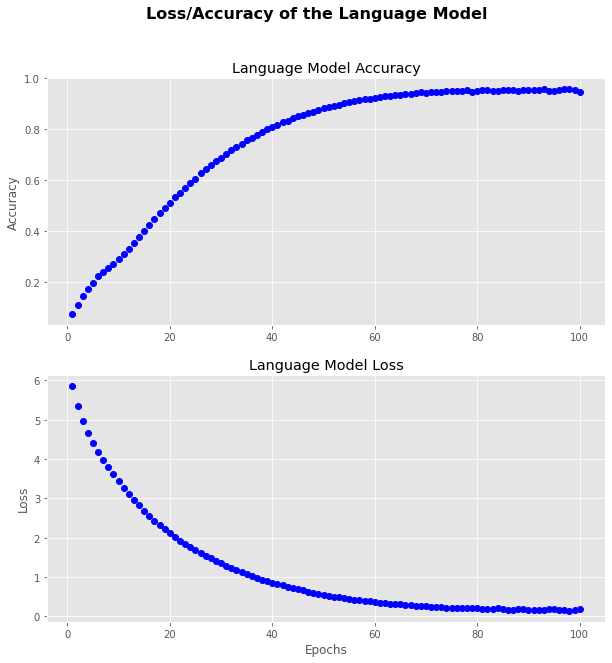

In [18]:
accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(accuracy) + 1)

plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
plot = ax1.plot(epochs, accuracy, 'bo', label='Accuracy')
plot = ax2.plot(epochs, loss, 'bo', label='Loss')
ax1.set(title='Language Model Accuracy', ylabel='Accuracy')
ax2.set(title='Language Model Loss', xlabel='Epochs', ylabel='Loss')

fig.suptitle('Loss/Accuracy of the Language Model', fontsize=16, fontweight = 'bold')

In [40]:
def generateText(seed):   #A text seed is provided
    for wordLength in range(45):   #Generates a text with a range of word length
        tokenList = tokenizer.texts_to_sequences([seed])[0]  #Turns the seed into sequences
        tokenList = pad_sequences([tokenList], maxlen=maxSequenceLen - 1, padding='pre')
        predicted = model.predict_classes(tokenList, verbose=0) #Predicts the next sequence(generated
        outputWord = " "                                         #text)  
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                outputWord = word
                break
        seed += " " + outputWord     #Returns the seed plus generated text
    return seed

In [41]:
generateText('my love')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'my love for you is so real that it makes me want to do unreal things like jumping on the clouds and climbing the rainbow i love you my dear husband i love you my sunshine filled with you i love you so much will forever i'

In [42]:
generateText('Honey')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'Honey i just want to let you know that i’ll always be around regardless of the tough situations this love will last forever so please allow me to love you more than i already do baby you surprise me i love you and i will continue'

In [43]:
generateText('Bumble bee')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'Bumble bee we may be tell my life to be better day and forever you are the reason i work so hard to make that perfect moment for you i love you so much my dear wife i love you till death tear us apart i want'

In [44]:
generateText('Loofu mi')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


"Loofu mi you are the most beautiful woman i have ever known you grew a flower in my heart which i call love i love you like everything else as nothing in this world can replace you over on me a happy a little midday i can't"

In [45]:
generateText('mi Love')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'mi Love is the air i breathe without you my darling i wouldn’t be alive because you have a piece of my heart and that’s why i need you by my side so much i love you my girl i love you my heart’s desire for you'

In [46]:
generateText('my Heartbeat')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'my Heartbeat god has blessed me with many things but the best part about is what is first day it was a crime which many lives we are weaned or from our memories that days is one of the perfect letter is the ideal time to write'